<a href="https://colab.research.google.com/github/SebastianNewberry/BeTheWhirlwind/blob/master/run_ollama_in_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Run Ollama in Colab

### Code to initialize llama using Unsloth was retrieved from

https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing#scrollTo=2eSvM9zX_2d3

In [61]:
%%capture
!pip install unsloth

In [62]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.3.18: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [63]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 1, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [64]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.2",
)

def formatting_train_prompts(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }

def tokenize_function(examples):
    return tokenizer(
        examples["text"],  # Use only text
        padding=True,
        truncation=True,
        max_length=2048,
        return_tensors="pt"
    )

from datasets import load_dataset

# Load the full dataset
full_dataset = load_dataset("mlabonne/FineTome-100k", split="train")

# Split the dataset into training and testing sets (e.g., 80% train, 20% test)
split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)

# Access the train and test splits
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

print(f"Train dataset: {train_dataset}")
print(f"Test dataset: {test_dataset}")

Train dataset: Dataset({
    features: ['conversations', 'source', 'score'],
    num_rows: 80000
})
Test dataset: Dataset({
    features: ['conversations', 'source', 'score'],
    num_rows: 20000
})


In [65]:
from unsloth.chat_templates import standardize_sharegpt
train_dataset = standardize_sharegpt(train_dataset)
train_dataset = train_dataset.map(formatting_train_prompts, batched = True,)
test_dataset = standardize_sharegpt(test_dataset)
test_dataset = test_dataset.map(formatting_train_prompts, batched=True)
tokenized_datasets = test_dataset.map(tokenize_function, batched=True)

In [66]:
from transformers import TrainerCallback

# Define a custom callback to capture the training and validation losses
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            # Capture training loss
            if "loss" in logs:
                self.train_losses.append(logs["loss"])

            # Capture validation loss (eval_loss)
            if "eval_loss" in logs:
                self.val_losses.append(logs["eval_loss"])

# Model Performance on 5 different categories outlined in question #1 before training

Prompt Type: Text Summarization


Response: system

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

user

Antibiotics are a type of medication used to treat bacterial infections. They work by either killing the bacteria or preventing them from reproducing, allowing the body’s immune system to fight off the infection. Antibiotics are usually taken orally in the form of pills, capsules, or liquid solutions, or sometimes administered intravenously. They are not effective against viral infections, and using them inappropriately can lead to antibiotic resistance.

user

Explain the above in one sentence.

assistant

Antibiotics are a type of medication that kill or prevent bacteria from reproducing, allowing the body's immune system to fight off infections, but they are ineffective against viral infections and can lead to antibiotic resistance if used improperly.



Prompt Type: Question Answering


Response: system

Cutting Knowledge Date: December 2023
Today Date: 26 July 

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Before Training Losses: {'Text Summarization': 2.865199327468872, 'Question Answering': 3.8765993118286133, 'Text Classification': 5.147534370422363, 'Role Playing': 4.508725166320801, 'Reasoning': 3.8330307006835938}


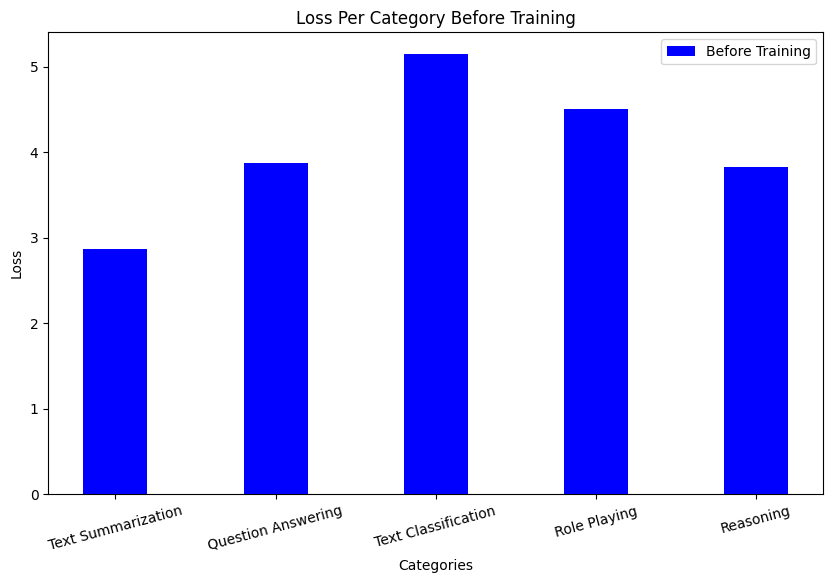

In [67]:
from unsloth.chat_templates import get_chat_template
import torch
from trl import SFTTrainer
import matplotlib.pyplot as plt
import numpy as np
from unsloth import is_bfloat16_supported
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq

# Assuming tokenizer and model are already loaded
tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama-3.2",
)

# Define a list of messages (each entry follows the chat template format)

message_list = [
    [# Text Summarization
     {"role": "user", "content": "Antibiotics are a type of medication used to treat bacterial infections. They work by either killing the bacteria or preventing them from reproducing, allowing the body’s immune system to fight off the infection. Antibiotics are usually taken orally in the form of pills, capsules, or liquid solutions, or sometimes administered intravenously. They are not effective against viral infections, and using them inappropriately can lead to antibiotic resistance.\n\n"},
     {"role": "user", "content": "Explain the above in one sentence.\n\n"}],

    [# Question Answering
     {"role": "user", "content": "Answer the question based on the context below. Keep the answer short and concise. Respond 'Unsure about answer' if not sure about the answer.\n\n"},
     {"role": "user", "content": "Context: Teplizumab traces its roots to a New Jersey drug company called Ortho Pharmaceutical. There, scientists generated an early version of the antibody, dubbed OKT3. Originally sourced from mice, the molecule was able to bind to the surface of T cells and limit their cell-killing potential. In 1986, it was approved to help prevent organ rejection after kidney transplants, making it the first therapeutic antibody allowed for human use.\n\n"},
     {"role": "user", "content": "Question: What was OKT3 originally sourced from?\n\n"}],

    [# Text Classification
     {"role": "user", "content": "Classify the text into neutral, negative or positive.\n\n"},
     {"role": "user", "content": "Text: I think the food was okay.\n\n"}],

    [# Role Playing
     {"role": "system", "content": "The following is a conversation with an AI research assistant. The assistant tone is technical and scientific.\n\n"},
     {"role": "user", "content": "Hello, who are you?\n\n"},
     {"role": "assistant", "content": "Greeting! I am an AI research assistant. How can I help you today?\n\n"},
     {"role": "user", "content": "Can you tell me about the creation of blackholes?\n\n"}],

    [# Reasoning
     {"role": "system", "content": "The odd numbers in this group add up to an even number: 15, 32, 5, 13, 82, 7, 1.\n\n"},
     {"role": "user", "content": "Solve by breaking the problem into steps. First, identify the odd numbers, add them, and indicate whether the result is odd or even.\n\n"}]
]

# Store results
generated_outputs = []
dataset = []
prompt_types = ["Text Summarization", "Question Answering", "Text Classification", "Role Playing", "Reasoning"]

# Iterate through message list and generate responses
for messages, prompt_type in zip(message_list, prompt_types):
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,  # Required for generation
        return_tensors="pt",
    ).to("cuda")

    # Run inference without gradient tracking
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=2048,
            use_cache=True,
            temperature=1.5,
            min_p=0.1
        )

    # Decode and store the output
    output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    generated_outputs.append(output_text)

    dataset.append({"input_ids": inputs, "label": prompt_type})  # Store input-label pairs

# Print all generated responses
for response, prompt_type in zip(generated_outputs, prompt_types):
    print(f"Prompt Type: {prompt_type}\n\n")

    print(f"Response: {response}\n\n\n")

# Initialize the callback
loss_logger = LossLoggerCallback()

# Create a trainer object with the custom callback
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer),
    dataset_num_proc=2,
    packing=False,
    eval_dataset=tokenized_datasets.select(range(100)),
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=256,
        warmup_steps=5,
        num_train_epochs=1,
        learning_rate=9e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1, # log training loss every 1 step
        evaluation_strategy="steps",  # Ensure validation happens periodically
        eval_steps=1,  # Evaluate every 1 step
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none"
    ),
    callbacks=[loss_logger]  # Attach the loss logger callback
)

# Function to compute loss per category
def compute_loss_per_category(dataset):
    trainer.model.eval()  # Ensure evaluation mode
    category_losses = {}

    for data in dataset:
        with torch.no_grad():
            result = trainer.evaluate({"input_ids": data["input_ids"].cpu()})  # Evaluate per input
            category_losses[data["label"]] = result["eval_input_ids_loss"]  # Store loss for category

    return category_losses

# Compute losses before training
before_training_losses = compute_loss_per_category(dataset)
print("Before Training Losses:", before_training_losses)

# Prepare data for visualization
categories = list(before_training_losses.keys())
before_losses = [before_training_losses[cat] for cat in categories]

# Plot bar chart
x = range(len(categories))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x, before_losses, width, label="Before Training", color="blue")

plt.xlabel("Categories")
plt.ylabel("Loss")
plt.title("Loss Per Category Before Training")
plt.xticks(x, categories, rotation=15)
plt.legend()
plt.show()

# Model performance on the representative dataset before training

In [68]:
messages_list = [[{"role": conv["role"], "content": conv["content"] + "\n\n"} for conv in message] for message in test_dataset["conversations"][:5]] # test the first 5 samples of the representative dataset that will be trained

# Store results
generated_outputs = []

# Iterate through message list and generate responses
for messages in messages_list:
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,  # Required for generation
        return_tensors="pt",
    ).to("cuda")

    # Run inference without gradient tracking
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=2048,
            use_cache=True,
            temperature=1.5,
            min_p=0.1
        )

    # Decode and store the output
    output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    generated_outputs.append(output_text)

for response in generated_outputs:
    print(f"Response: {response}\n\n\n")

Response: system

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

user

Give three types of computer graphics.

assistant

1. Raster Graphics: These are also called bitmap graphics and are composed of pixels arranged in a grid. Each pixel can have a different color and shade. Raster graphics excel at representing photographic images and digital painting.

2. Vector Graphics: These graphics are constructed using mathematical formulas representing geometric shapes like lines, curves, and polygons. They are resolution-independent, meaning they can be scaled up or down in size without losing quality. Vector graphics are commonly used for logos, icons, typography and illustrations.

3. 3D Graphics: These graphics are used to create three-dimensional digital representations of objects. 3D graphics use techniques like modeling, rendering, and shading to simulate depth and surface properties. These graphics are used in animation, video games, architecture, engineering, and virt

# Fine-tuning using LORA and SFTTrainer which is a special trainer designed to fine-tune models.

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80,000 | Num Epochs = 1 | Total steps = 156
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 256
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 256 x 1) = 512
 "-____-"     Trainable parameters = 1,519,616/3,214,269,440 (0.05% trained)


Step,Training Loss,Validation Loss,Model Preparation Time
1,1.384800,1.506838,0.006800
2,1.412400,1.452219,0.006800
3,1.369100,1.308331,0.006800
4,1.198800,1.187505,0.006800
5,1.111200,1.105656,0.006800
6,1.012400,1.062364,0.006800
7,0.978900,1.030854,0.006800
8,0.944300,1.012546,0.006800
9,0.937000,1.000522,0.006800
10,0.908100,0.988544,0.006800


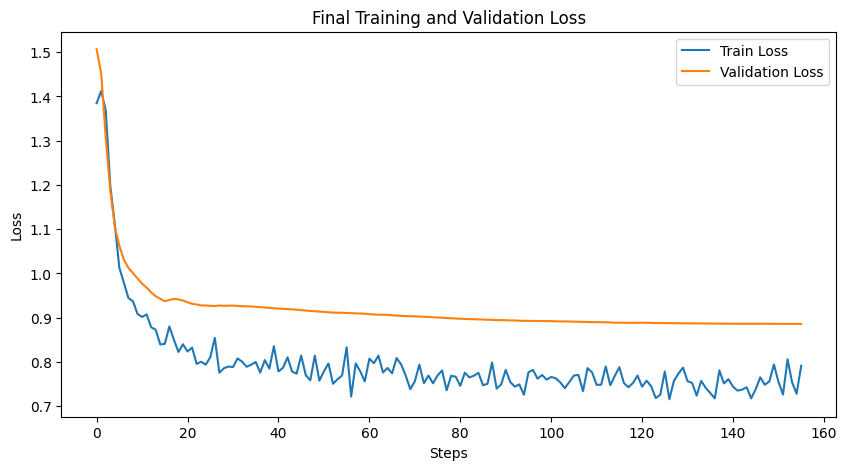

In [69]:
# Train the model
trainer.train()

# Final plot after training is complete
plt.figure(figsize=(10, 5))
plt.plot(loss_logger.train_losses, label='Train Loss')
plt.plot(loss_logger.val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Final Training and Validation Loss')
plt.legend()
plt.show()

#Model performance on representative examples from the dataset after training

In [70]:
messages_list = [[{"role": conv["role"], "content": conv["content"] + "\n\n"} for conv in message] for message in test_dataset["conversations"][:5]] # test the first 5 samples of the representative dataset that will be trained

# Store results
generated_outputs = []

# Iterate through message list and generate responses
for messages in messages_list:
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,  # Required for generation
        return_tensors="pt",
    ).to("cuda")

    # Run inference without gradient tracking
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=2048,
            use_cache=True,
            temperature=1.5,
            min_p=0.1
        )

    # Decode and store the output
    output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    generated_outputs.append(output_text)

for response in generated_outputs:
    print(f"Response: {response}\n\n\n")

Response: system

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

user

Give three types of computer graphics.

assistant

1. Raster Graphics: These are also called bitmap graphics and are composed of pixels arranged in a grid. Each pixel can have a different color and shade. Raster graphics excel at representing photographic images and digital painting.

2. Vector Graphics: These graphics are constructed using mathematical formulas representing geometric shapes like lines, curves, and polygons. They are resolution-independent, meaning they can be scaled up or down in size without losing quality. Vector graphics are commonly used for logos, icons, typography and illustrations.

3. 3D Graphics: These graphics are used to create three-dimensional digital representations of objects. 3D graphics use techniques like modeling, rendering, and shading to simulate depth and surface properties. These graphics are used in animation, video games, architecture, engineering, and virt

# Model performance on the 5 different categories in question #1 after training

Prompt Type: Text Summarization


Response: system

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

user

Antibiotics are a type of medication used to treat bacterial infections. They work by either killing the bacteria or preventing them from reproducing, allowing the body’s immune system to fight off the infection. Antibiotics are usually taken orally in the form of pills, capsules, or liquid solutions, or sometimes administered intravenously. They are not effective against viral infections, and using them inappropriately can lead to antibiotic resistance.

user

Explain the above in one sentence.

assistant

Antibiotics are a type of medication that kill or inhibit the growth of bacteria, and they are taken orally or intravenously to treat bacterial infections, but they do not work against viruses.



Prompt Type: Question Answering


Response: system

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

user

Answer the question based on the context below

After Training Losses: {'Text Summarization': 1.1463937759399414, 'Question Answering': 2.299229621887207, 'Text Classification': 1.3443454504013062, 'Role Playing': 1.5592041015625, 'Reasoning': 1.648827314376831}


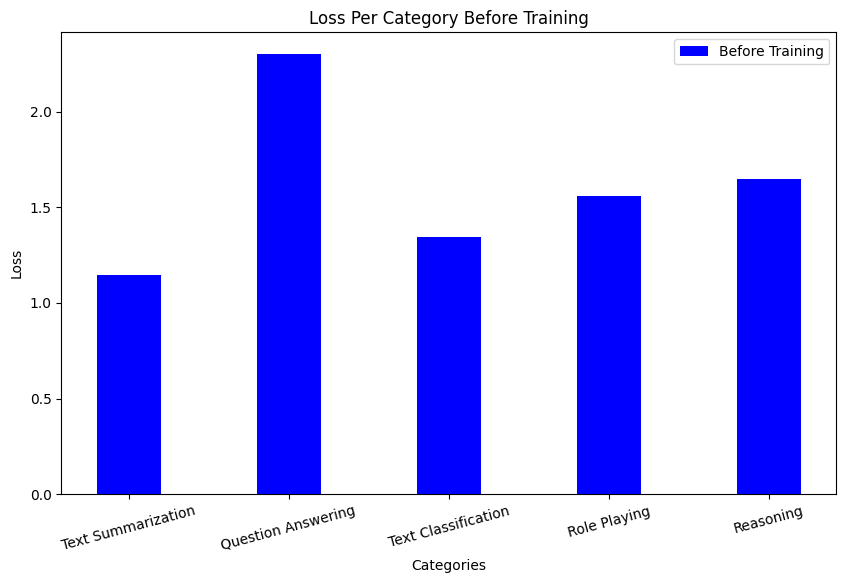

In [71]:
from unsloth.chat_templates import get_chat_template
import torch
from trl import SFTTrainer
import matplotlib.pyplot as plt
import numpy as np
from unsloth import is_bfloat16_supported
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq

# Assuming tokenizer and model are already loaded
tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama-3.2",
)

# Define a list of messages (each entry follows the chat template format)

message_list = [
    [# Text Summarization
     {"role": "user", "content": "Antibiotics are a type of medication used to treat bacterial infections. They work by either killing the bacteria or preventing them from reproducing, allowing the body’s immune system to fight off the infection. Antibiotics are usually taken orally in the form of pills, capsules, or liquid solutions, or sometimes administered intravenously. They are not effective against viral infections, and using them inappropriately can lead to antibiotic resistance.\n\n"},
     {"role": "user", "content": "Explain the above in one sentence.\n\n"}],

    [# Question Answering
     {"role": "user", "content": "Answer the question based on the context below. Keep the answer short and concise. Respond 'Unsure about answer' if not sure about the answer.\n\n"},
     {"role": "user", "content": "Context: Teplizumab traces its roots to a New Jersey drug company called Ortho Pharmaceutical. There, scientists generated an early version of the antibody, dubbed OKT3. Originally sourced from mice, the molecule was able to bind to the surface of T cells and limit their cell-killing potential. In 1986, it was approved to help prevent organ rejection after kidney transplants, making it the first therapeutic antibody allowed for human use.\n\n"},
     {"role": "user", "content": "Question: What was OKT3 originally sourced from?\n\n"}],

    [# Text Classification
     {"role": "user", "content": "Classify the text into neutral, negative or positive.\n\n"},
     {"role": "user", "content": "Text: I think the food was okay.\n\n"}],

    [# Role Playing
     {"role": "system", "content": "The following is a conversation with an AI research assistant. The assistant tone is technical and scientific.\n\n"},
     {"role": "user", "content": "Hello, who are you?\n\n"},
     {"role": "assistant", "content": "Greeting! I am an AI research assistant. How can I help you today?\n\n"},
     {"role": "user", "content": "Can you tell me about the creation of blackholes?\n\n"}],

    [# Reasoning
     {"role": "system", "content": "The odd numbers in this group add up to an even number: 15, 32, 5, 13, 82, 7, 1.\n\n"},
     {"role": "user", "content": "Solve by breaking the problem into steps. First, identify the odd numbers, add them, and indicate whether the result is odd or even.\n\n"}]
]

# Store results
generated_outputs = []
dataset = []
prompt_types = ["Text Summarization", "Question Answering", "Text Classification", "Role Playing", "Reasoning"]

# Iterate through message list and generate responses
for messages, prompt_type in zip(message_list, prompt_types):
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,  # Required for generation
        return_tensors="pt",
    ).to("cuda")

    # Run inference without gradient tracking
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=2048,
            use_cache=True,
            temperature=1.5,
            min_p=0.1
        )

    # Decode and store the output
    output_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    generated_outputs.append(output_text)

    dataset.append({"input_ids": inputs, "label": prompt_type})  # Store input-label pairs

# Print all generated responses
for response, prompt_type in zip(generated_outputs, prompt_types):
    print(f"Prompt Type: {prompt_type}\n\n")

    print(f"Response: {response}\n\n\n")

# Function to compute loss per category
def compute_loss_per_category(dataset):
    trainer.model.eval()  # Ensure evaluation mode
    category_losses = {}

    for data in dataset:
        with torch.no_grad():
            result = trainer.evaluate({"input_ids": data["input_ids"].cpu()})  # Evaluate per input
            category_losses[data["label"]] = result["eval_input_ids_loss"]  # Store loss for category

    return category_losses

# Compute losses before training
after_training_losses = compute_loss_per_category(dataset)
print("After Training Losses:", after_training_losses)

# Prepare data for visualization
categories = list(after_training_losses.keys())
before_losses = [after_training_losses[cat] for cat in categories]

# Plot bar chart
x = range(len(categories))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x, before_losses, width, label="Before Training", color="blue")

plt.xlabel("Categories")
plt.ylabel("Loss")
plt.title("Loss Per Category Before Training")
plt.xticks(x, categories, rotation=15)
plt.legend()
plt.show()